# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2022

Integrante: Fanny Ruales

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por
$$\pi(a \mid s) = 1 - \epsilon$$ si $a$ es la mejor acción, caso contrario $$\pi(a \mid s) = \epsilon$$

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, done, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.

* ```seed(self)``` : Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [ ]:
#@title Código básico de graficación (no modificar)

import numpy as np
import matplotlib.pyplot as plt
import itertools
import gym

def plot_reward_per_episode(reward_ep):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    return reward_per_episode

#-------------------------    
def plot_steps_per_episode(timesteps_ep):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)

    return np.array(range(0, len(episode_steps))), episode_steps
    
 ######################################################
def graficar(reward_ep, timesteps_ep):
    plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(plot_reward_per_episode(reward_ep))
    plt.legend(['Recompensa acumulada por episodio'])
    plt.grid(True)

    plt.subplot(212)
    x, y = plot_steps_per_episode(timesteps_ep)
    plt.plot(x, y)
    plt.plot(plot_steps_per_episode_smooth(timesteps_ep))
    plt.legend(['Pasos por episodio', 'Pasos acumulados por episodio'])
    plt.grid(True)
    
    plt.show()

 # -------------------
def plot_steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

    return steps_per_episode

def draw_value_matrix(q):

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):

            state_values = []

            for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

            maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar) para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])):

        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = 'D'
        best_action = down_action

        if best_action < right_action:
            arrow_direction = 'R'
            best_action = right_action
        if best_action < left_action:
            arrow_direction = 'L'
            best_action = left_action
        if best_action < up_action:
            arrow_direction = 'U'
            best_action = up_action
        if best_action == -1:
            arrow_direction = ''

        # notar que column, row están invertidos en orden en la línea de abajo porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print('\n Matriz de mejor acción-valor (en números): \n\n', q_value_matrix)

Ejemplo: agente CartPole son agentes clasicos 

In [ ]:
import gym
import time
import numpy as np  ### AGREGE YO
import random ### AGREGE YO
import itertools ### AGREGE YO
import gym ### AGREGE YO

from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0')
    env.reset()
    for _ in range(500):
        env.render(mode='human')
        observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car agente clasico

In [ ]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    observation = env.reset()
    for t in range(500):
        env.render(mode='human')
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff. 
algo que muestra on policy y off policy 

![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

###1. Implementar y ejecutar el algoritmo SARSA y Q-Learning en "The Cliff".

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

**Comentario:**A la función *choose_action*, método de selección de acciones de nuestro agente y que utiliza la política de exploración  ϵ -greedy, le realizaremos un ajuste de tal forma que pueda ser utilizada por los diferentes algoritmos que usaremos, los cuales son SARSA y Q-Learning. <br> Observar que cuando *algoritmo* es distinto de cero, se ejecuta el algoritmo Q-Learning, devolviendo la mejor accion, la accion asociada con el valor mas alto.<br> 

In [ ]:
# colocamos como parametro el algoritmo a utilizar.
# "state" es el estado actual.
# "algoritmo" permite utilizar, o no, la elección de acciones al azar mediante épsilon.
    
# Inicializamos las acciones en 0.
def choose_action(state, algoritmo):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]  # ej: para 4 acciones inicializa en [0,0,0,0]
    max_q = max(q_values)
    
    #aqui entroducimos un pequeño ajuste a los fines de poder identificar que modelo estamos usando SARSA o Q-Learning
    if algoritmo == 0:
     if random_state.uniform() < epsilon:  # sorteamos un número: es menor a épsilon?
        return random_state.choice(actions)  # sí: se selecciona una acción aleatoria
    
    count = q_values.count(max_q)

    
    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

**Comentario:**Acá definimos el método learn. El cuál toma una transición y cambia los valores de Q de acuerdo al *algoritmo* seleccionado:

In [ ]:
#''' Método que realiza la actualización de los pares estado-acción.
    
#        Si es SARSA, existe la posibilidad de que la acción seleccionada sea aleatoria. Por otro lado, con
#        Q-Learning, siempre será elegida la mejor acción.
 
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    # TODO - completa con tu código aquí

    q[(state, action)] += alpha * (reward + gamma * q[(next_state, next_action)] - q[(state, action)])
    
    pass

**4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad**

**Comentario** La política  ϵ -greedy, utilizada anteriormente en la función "choose_action", elige la mejor acción (es decir, la acción asociada con el valor más alto) con probabilidad  1−ϵ  y una acción aleatoria con probabilidad  ϵ .<br>
El problema con esta política es que, cuando elige las acciones aleatorias, es decir, con probabilidad ϵ, las elige de manera uniforme, en otras palabras, considera todas las acciones igualmente buenas, incluso aunque ciertas acciones (incluso excluyendo la mejor actualmente) son mejores que otras.<br>
Por lo tanto, una solución a este problema es utilizar "**Softmax**", que consiste en seleccionar las acciones aleatorias con probabilidades en relación a sus valores actuales, es decir, asignar probabilidades a cada una de las acciones disponibles en un estado en función del valor que representen para  Q .<br>
Implementamos la política de exploración Softmax, donde la probabilidad de una acción  a  en un estado  s  está dada por:<br><br>
π(a∣s)=eQ(s,a)/τ∑a′eQ(s,a′)/τ<br><br> 
Donde τ es una variable de control que en los sistemas físicos representa
a la temperatura. Si la temperatura es 0 se obtiene la estrategia greedy. Al 
aumentar la temperatura se aumenta la exploración.<br>
Se puede utilizar una temperatura constante, o bien una temperatura
inicial alta (mucha exploración inicial) que vaya disminuyendo (mayor 
explotación al final).

In [ ]:
def choose_action_softmax(state,tau):
    p = np.array([q[(state,x)] for x in range(env.action_space.n)])
    prob_actions = np.exp(p/tau) / np.sum(np.exp(p/tau))
    cumulative_probability = 0.0
    choice = random.uniform(0,1)
    
    for a,pr in enumerate(prob_actions):
        cumulative_probability += pr
        if cumulative_probability > choice:
            return a

Finalmente, definimos el método principal de iteraciones. 

**Comentario:** El método run será el encargado de correr las pruebas según los parámetros que le hayamos otorgado:

In [ ]:
# se ha realizado ajustes a los fines de poder ejecutar uno u otro algoritmo y considerando que politica se utiliza.

def run(algoritmo=0, softmax=False):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual
        #action = choose_action(state)

        # Elige una acción basado en el estado actual.
        if softmax == True:
            action = choose_action_softmax(state,tau)
        else:
            action = choose_action(state, 0)
        



        
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
            
            # next_action = choose_action(next_state) comento para agregar lo de Q-Learning

            if softmax == True:
              next_action = choose_action_softmax(state,tau)
            else:
              next_action = choose_action(next_state, algoritmo)
            
            # fin mi intervencion

            episode_reward += reward
            learn(state, action, reward, next_state, next_action)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [ ]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# Generamos siempre la "semilla aleatorio", para repetir las pruebas.
seed_val = 42
env.seed(seed_val)
np.random.seed(seed_val)
random_state = np.random.RandomState(42)



from collections import defaultdict
q = defaultdict(int)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

Ya instanciado, ejecutamos nuestro agente

### Ejecutamos nuestro agente con metodo SARSA

In [ ]:
# "SARSA" (usando 0) o "Q-Learning" (colocando cualquier otro valor).

# Iniciamos las corridas del agente, utilizando "SARSA" en este caso.
avg_reward_per_episode_sarsa, timesteps_ep_sarsa, reward_ep_sarsa = run()
#graficar(reward_ep_sarsa, timesteps_ep_sarsa)
#draw_value_matrix(q)
env.close()

### Ejecutamos nuestro agente con Metodo Q-Learning

Instanciamos a nuestro agente.

In [ ]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# Generamos siempre la "semilla aleatorio", para repetir las pruebas.
seed_val = 42
env.seed(seed_val)
np.random.seed(seed_val)
random_state = np.random.RandomState(42)

from collections import defaultdict
q = defaultdict(int)

In [ ]:
# Iniciamos las corridas del agente, utilizando "Q-Learning" en este caso.
avg_reward_per_episode, timesteps_ep, reward_ep = run(1)

#graficar(reward_ep, timesteps_ep)

#draw_value_matrix(q)
env.close()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

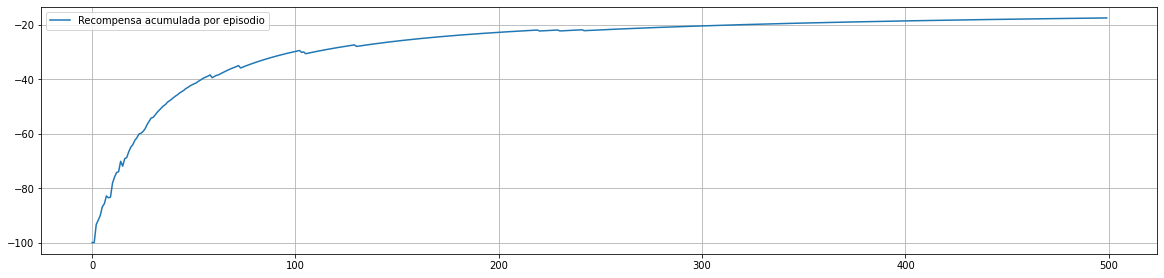

In [ ]:
#plot_reward_per_episode(reward_ep)

# Graficamos los valores obtenidos.
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(plot_reward_per_episode(reward_ep))
plt.legend(['Recompensa acumulada por episodio'])
plt.grid(True)
plt.show()  


Veamos pasos por episodio

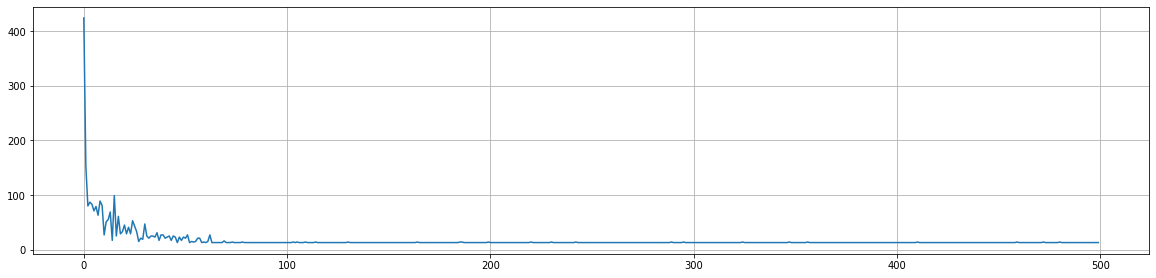

In [ ]:
#plot_steps_per_episode(timesteps_ep)
plt.figure(figsize=(20,10))
plt.subplot(212)
x, y = plot_steps_per_episode(timesteps_ep)
plt.plot(x, y)
plt.grid(True)
plt.show() 

Suavizando...

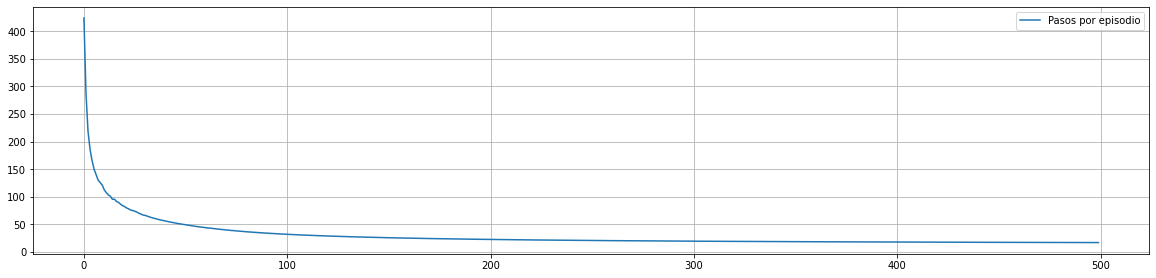

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(212)
plt.plot(plot_steps_per_episode_smooth(timesteps_ep))
plt.legend(['Pasos por episodio', 'Pasos acumulados por episodio'])
plt.grid(True)
plt.show() 

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

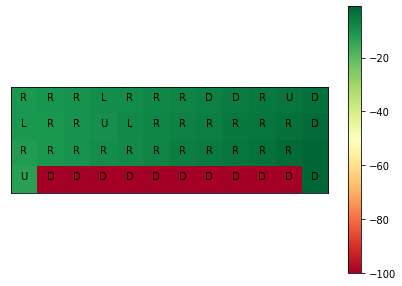


 Matriz de mejor acción-valor (en números): 

 [[ -11.13343469  -10.58530622   -9.90905571   -9.07265364   -8.51051259
    -7.61129476   -6.90601182   -6.15907045   -5.33670743   -4.55095196
    -3.7265625    -2.94822403]
 [ -11.41914859  -10.81652032   -9.97657994   -9.14408637   -8.3320666
    -7.53224571   -6.65580486   -5.73870599   -4.84581139   -3.93669498
    -2.98743555   -1.99984102]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [ ]:
draw_value_matrix(q)

In [ ]:
env.close()

###2. ¿Cómo converge Q-Learning respecto a SARSA? ¿A qué se debe? Comentar.

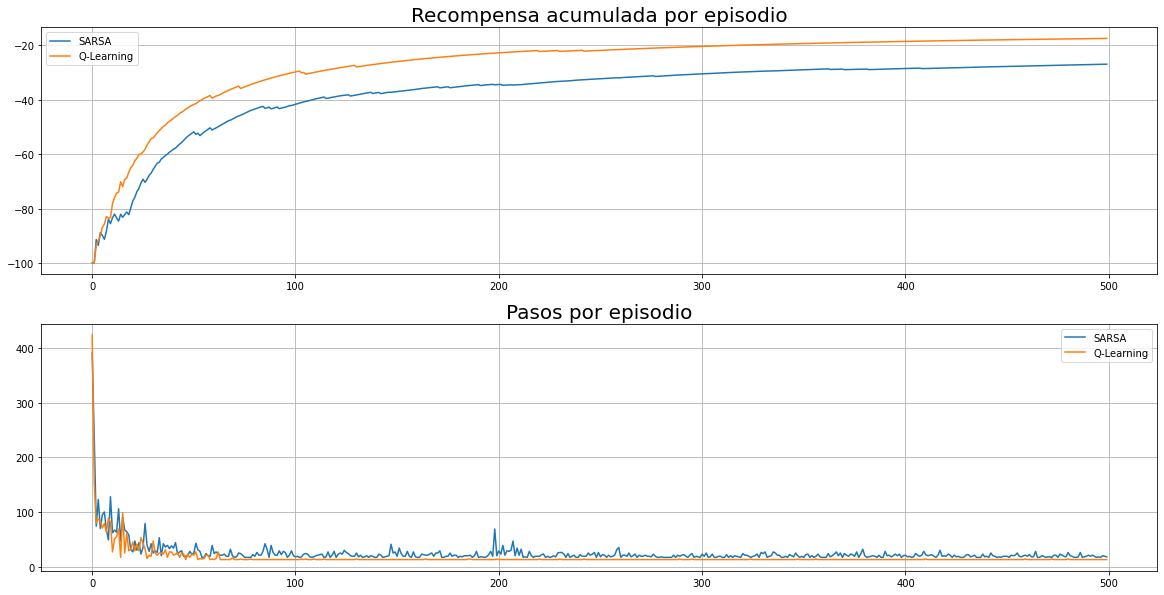

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(211)
plt.title('Recompensa acumulada por episodio', fontsize = 20)
plt.plot(plot_reward_per_episode(reward_ep_sarsa))
plt.plot(plot_reward_per_episode(reward_ep))
plt.legend(['SARSA', 'Q-Learning'])
plt.grid(True)

plt.subplot(212)
plt.title('Pasos por episodio', fontsize = 20)
x, y = plot_steps_per_episode(timesteps_ep_sarsa)
plt.plot(x, y)
x, y = plot_steps_per_episode(timesteps_ep)
plt.plot(x, y)
plt.legend(['SARSA', 'Q-Learning'])
plt.grid(True)

plt.show()

**Conclusion**:<br> Podemos apreciar en las graficas realizadas que el agente obtiene recompensas mas elevadas la cantidad de pasos disminuye sustancialmente para el metodo Q-Learning en relacion al metodo SARSA, ¿pero a que se debe esto? la respuesta puede darnosla el hiperparametro *epsilon* definida de 0.1 que provoca en el metodo de SARSA explore el 90% del tiempo y el 10% se encuentra explorando nuevas opciones. Mientras que Q-Learning aprende la politica optima, considerando las acciones que maximicen la recompensa, por este motivo este metodo converge mas rapido. Dicho de esta manera, pareciera que Q-Learning es mucho mejor metodo, pero se debe considerar que si el entorno cambia SARSA tendra menores rendimientos debido a su caracteristica exploratoria.

###3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de  α ,  ϵ  y  γ .

####Tasa de Aprendizaje, Alpha

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

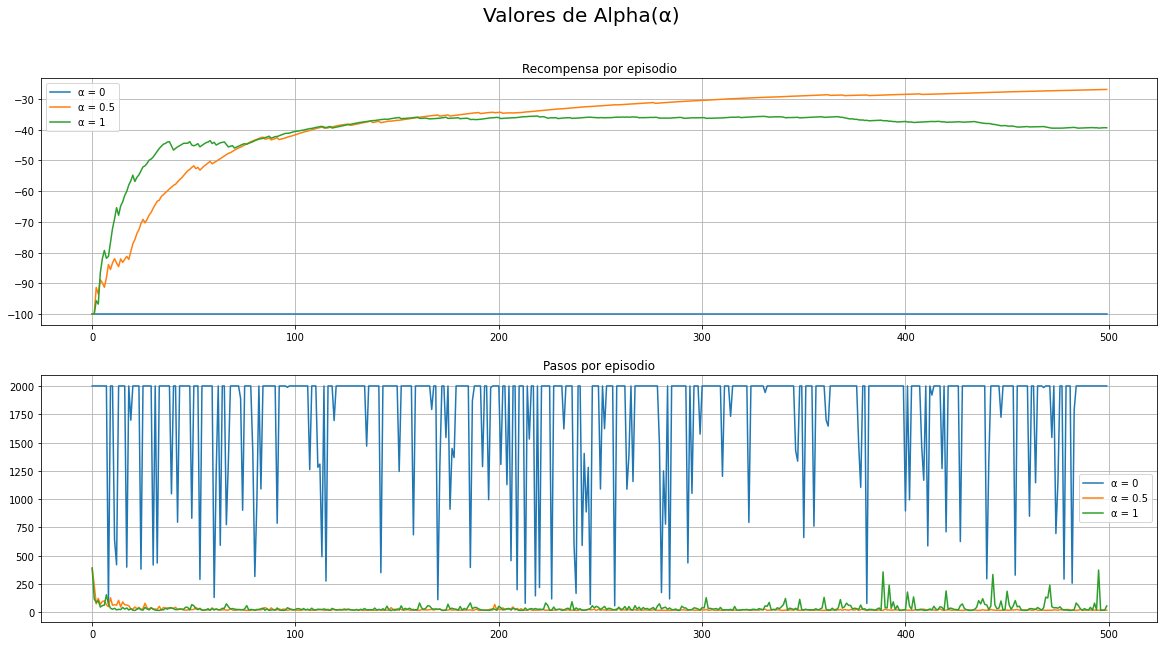

In [ ]:
# Definimos los híper-parámetros básicos.
alpha_valores = [0,0.5,1]
gamma = 1
epsilon = 0.1

# Definimos la cantidad de episodios a correr.
episodes_to_run = 500

plt.figure(figsize=(20,10))
plt.suptitle('Valores de Alpha(α)', fontsize = 20)

for alpha in alpha_valores:
    # Generamos el entorno para el agente, en este caso, el escenario "The Cliff".
    env = gym.make('CliffWalking-v0')

    # Generamos siempre la "semilla aleatorio", para repetir las pruebas.
    seed_val = 42
    env.seed(seed_val)
    np.random.seed(seed_val)
    random_state = np.random.RandomState(42)

    # Obtenemos las acciones disponibles para el entorno.
    actions = range(env.action_space.n)

    # Creamos el diccionario que contendrá los valores de Q para cada tupla (estado, acción).
    q = defaultdict(int)

    avg_reward_per_episode, timesteps_ep, reward_ep = run()
    
    # Graficamos los valores obtenidos.
    plt.subplot(211)
    plt.plot(plot_reward_per_episode(reward_ep))
    
    x, y = plot_steps_per_episode(timesteps_ep)
    plt.subplot(212)
    plt.plot(x, y)

    env.close()

plt.subplot(211)
plt.title('Recompensa por episodio')
plt.legend(['α = 0', 'α = 0.5', 'α = 1'])
plt.grid(True)

plt.subplot(212)
plt.title('Pasos por episodio')
plt.legend(['α = 0', 'α = 0.5', 'α = 1'])
plt.grid(True)

plt.show()

**Conclusion:**<br> Este establecerá y determinará hasta qué punto la información adquirida 
sobrescribe la información vieja. Un ratio de aprendizaje igual a 0 hace que el agente 
no aprenda, aprovechando así únicamente el conocimiento previo, mientras que en el 
caso opuesto, con un ratio de aprendizaje igual a 1 hace que el agente solo tenga en 
cuenta la información más reciente, ignorando el conocimiento previo, para explorar 
nuevas posibilidades).

####Factor de descuento (𝜸)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

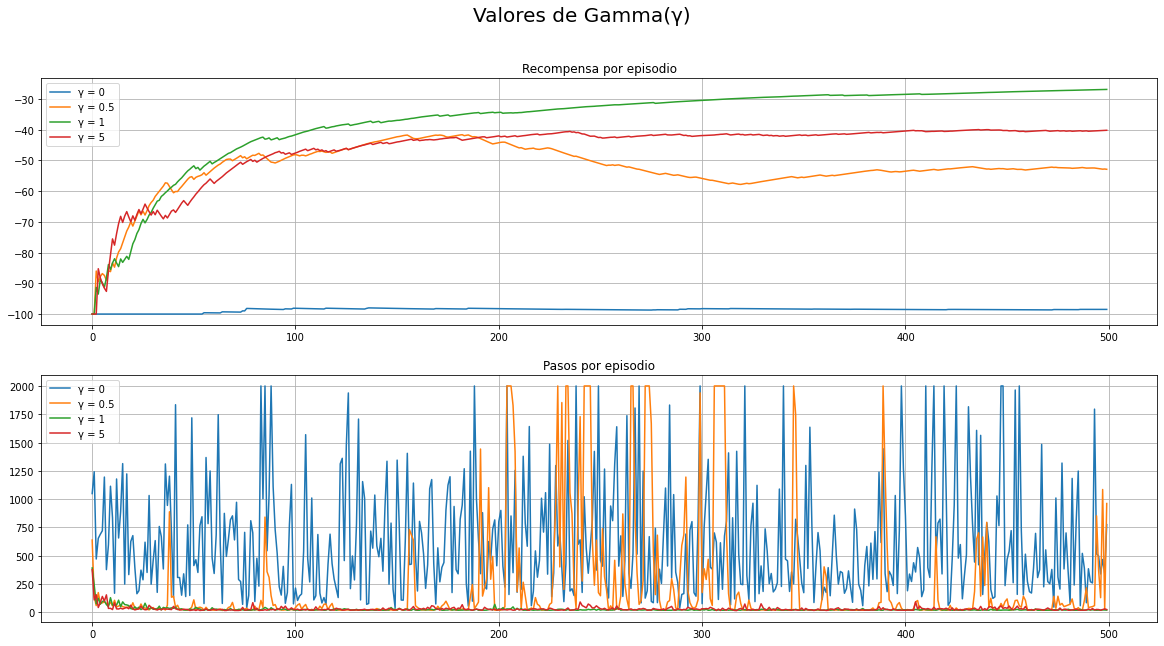

In [ ]:
# Definimos los híper-parámetros básicos.
alpha = 0.5
epsilon = 0.1
gamma_valores = [0,0.5,1,5]

plt.figure(figsize=(20,10))
plt.suptitle('Valores de Gamma(γ)', fontsize = 20)

for gamma in gamma_valores:
    # Generamos el entorno para el agente, en este caso, el escenario "The Cliff".
    env = gym.make('CliffWalking-v0')

    # Generamos siempre la "semilla aleatorio", para repetir las pruebas.
    seed_val = 42
    env.seed(seed_val)
    np.random.seed(seed_val)
    random_state = np.random.RandomState(42)

    # Obtenemos las acciones disponibles para el entorno.
    actions = range(env.action_space.n)

    # Creamos el diccionario que contendrá los valores de Q para cada tupla (estado, acción).
    q = defaultdict(int)

    avg_reward_per_episode, timesteps_ep, reward_ep = run()
    
    # Graficamos los valores obtenidos.
    plt.subplot(211)
    plt.plot(plot_reward_per_episode(reward_ep))
    
    x, y = plot_steps_per_episode(timesteps_ep)
    plt.subplot(212)
    plt.plot(x, y)
    
    env.close()

plt.subplot(211)
plt.title('Recompensa por episodio')
plt.legend(['γ = 0', 'γ = 0.5', 'γ = 1', 'γ = 5'])
plt.grid(True)

plt.subplot(212)
plt.title('Pasos por episodio')
plt.legend(['γ = 0', 'γ = 0.5', 'γ = 1', 'γ = 5'])
plt.grid(True)

plt.show()

**Conclusion:**<br> Este 
determina la importancia de recompensas futuras. Un factor de 0 hará que el agente no 
tenga en cuenta posibles recompensas futuras, considerando así únicamente las 
recompensas actuales. Mientras que un factor de 1 hará que el agente “luche” por una 
recompensa alta a largo plazo.

####Épsilon -  ϵ

Uno de los desafíos más grandes que existen en el aprendizaje por refuerzo es el balance 
entre explotación y exploración.<br>
• Explotación. Como su propio nombre indica, el agente debe explotar lo que le ha funcionado y ha aprendido en el pasado.<br>
• Exploración. El agente explora el entorno, realizando acciones aleatorias, lo que lo lleva a descubrir el entorno.<br>
Tomar alguna de las dos opciones exclusivamente llevará a error, si el agente únicamente se dedica a explorar, pero no tiene en cuenta lo que va aprendiendo, se dedica a tomar únicamente acciones aleatorias, por otro lado, si agente explota pero no explora lo suficiente, puede que tome una serie de acciones y puede no llegar a descubrir todas las acciones posibles.<br> 
Es por ello que estas dos opciones deben estar balanceadas progresivamente, y para ello usamos la estrategia conocida como Epsilon-greedy para la toma de 
decisiones.<br> Si el valor random obtenido durante la funcion, como está implementada en el método choose_action, es menor que el valor de  ϵ  entonces se tomará una acción al azar mirando  Q  en ese estado. Por otro lado, si es mayor a  ϵ  entonces se explotará el modelo.

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

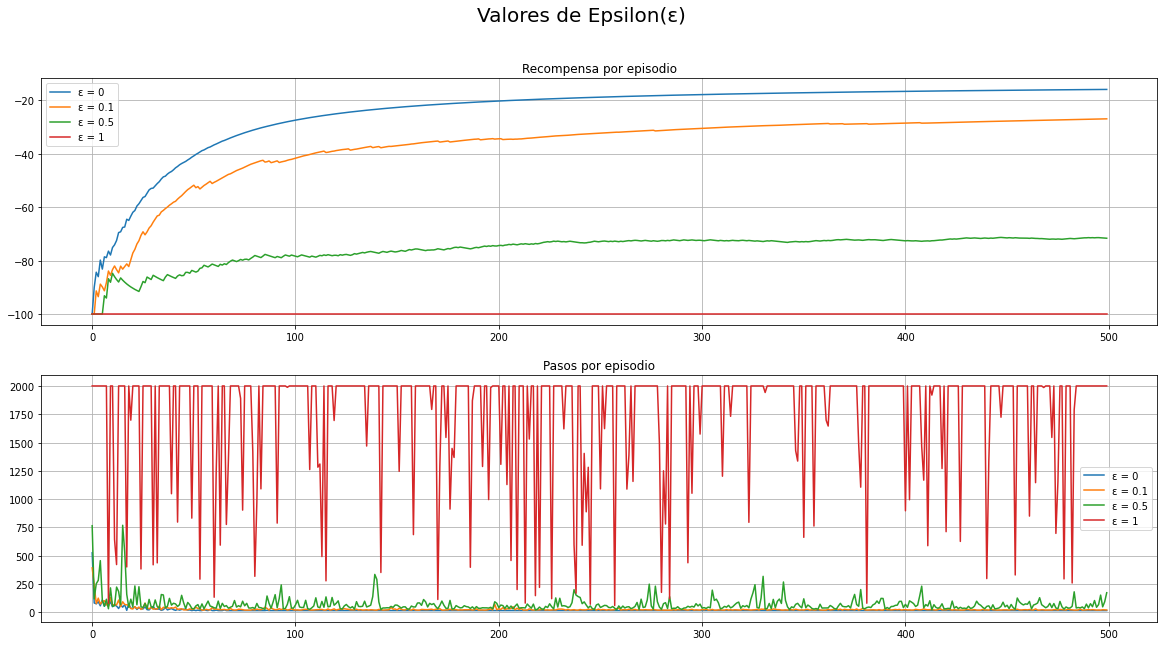

In [ ]:
#Definimos los híper-parámetros básicos.
epsilon_valores = [0,0.1,0.5,1]
alpha = 0.5
gamma = 1

plt.figure(figsize=(20,10))
plt.suptitle('Valores de Epsilon(ε)', fontsize = 20)

for epsilon in epsilon_valores:
    # Generamos el entorno para el agente, en este caso, el escenario "The Cliff".
    env = gym.make('CliffWalking-v0')

    # Generamos siempre la "semilla aleatorio", para repetir las pruebas.
    seed_val = 42
    env.seed(seed_val)
    np.random.seed(seed_val)
    random_state = np.random.RandomState(42)

    # Obtenemos las acciones disponibles para el entorno.
    actions = range(env.action_space.n)

    # Creamos el diccionario que contendrá los valores de Q para cada tupla (estado, acción).
    q = defaultdict(int)

    avg_reward_per_episode, timesteps_ep, reward_ep = run()
    
    # Graficamos los valores obtenidos.
    plt.subplot(211)
    plt.plot(plot_reward_per_episode(reward_ep))
    
    x, y = plot_steps_per_episode(timesteps_ep)
    plt.subplot(212)
    plt.plot(x, y)

    env.close()
    
plt.subplot(211)
plt.title('Recompensa por episodio')
plt.legend(['ε = 0', 'ε = 0.1', 'ε = 0.5', 'ε = 1'])
plt.grid(True)

plt.subplot(212)
plt.title('Pasos por episodio')
plt.legend(['ε = 0', 'ε = 0.1', 'ε = 0.5', 'ε = 1'])
plt.grid(True)
    
plt.show()

Conclusión
Como podemos observar en las gráficas, vemos que:

Un factor  ϵ  cercano a 0 hace que el agente se dedique a tomar acciones aleatorias y explorar durante un porcentaje pequeño de veces, por lo que la mayor parte del tiempo está explotando.
Por otro lado, con un  ϵ  cercano a 1, hacemos que el agente esté explorando en la totalidad o la mayor parte del tiempo, haciendo que nunca pueda explotar las acciones aprendidas, generando un reward cada vez más bajo (como se observa en la gráfica).
Lo ideal en este caso sería, por ejemplo, colocar un valor de  ϵ  como el que veníamos utilizando, de  0.1 , para que nuestro agente explote la mayor parte del tiempo, mientras que un porcentaje menor de veces explore y detecte cambios en el entorno o algún camino mejor. 

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN